In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NPY after 1971

In [2]:
cp = pd.read_csv("../data/COMPUSTAT.csv")

In [3]:
cp = cp[(cp["dvc"] >= 0) & (cp["prstkc"] >= 0) & (cp["pstkrv"] >= 0) & (cp["sstk"] >= 0)].dropna()
cp["np_new"] = cp["dvc"] + cp["prstkc"] - cp["sstk"]

# CRSP: mkt cap, volatility, momentum

In [4]:
crsp = pd.read_csv("../data/CRSP/Monthly.csv")
crsp["PRC"] = np.abs(crsp["PRC"])
crsp["RET"] = pd.to_numeric(crsp["RET"], errors='coerce')
crsp["RET"] = crsp["RET"].clip(-1, 5)
crsp["RETX"] = pd.to_numeric(crsp["RETX"], errors='coerce')
crsp["RETX"] = crsp["RETX"].clip(-1, 5)

In [5]:
crsp["dividend_yield"] = crsp["RET"] - crsp["RETX"]

## Market cap

In [6]:
crsp["cap"] = crsp["PRC"] * crsp["SHROUT"]
crsp["prev_cap"] = crsp.groupby("PERMNO")["cap"].shift(1)

year_end_cap = crsp[crsp["date"] % 10000 // 100 == 12].copy()
year_end_cap["fyear"] = year_end_cap["date"] // 10000
year_end_cap.rename(columns={"cap": "year_end_cap"}, inplace=True)
year_end_cap = year_end_cap[["PERMNO", "fyear", "year_end_cap"]]

## Net issuance

In [7]:
crsp["adj_shrout"] = crsp["SHROUT"] * crsp["CFACSHR"]
crsp["adj_prc"] = crsp["PRC"] / crsp["CFACPR"]

crsp["dshrout"] = crsp.groupby("PERMNO")["adj_shrout"].diff()
crsp["prev_adj_prc"] = crsp.groupby("PERMNO")["adj_prc"].shift(1)
crsp["prev_prc"] = crsp.groupby("PERMNO")["PRC"].shift(1)

crsp["ni_old"] = crsp["dshrout"] * (crsp["prev_prc"] + crsp["PRC"]) / 2 
crsp["ni_old_adj"] = crsp["dshrout"] * (crsp["prev_adj_prc"] + crsp["adj_prc"]) / 2

In [8]:
crsp["fyear"] = crsp["date"] // 10000 

In [9]:
yearly_net_issuance = crsp.groupby(["PERMNO", "fyear"], as_index=False)[["ni_old", "ni_old_adj", "dividend_yield"]].sum()

In [10]:
yearly_net_issuance = pd.merge(yearly_net_issuance, year_end_cap)

In [11]:
cp = pd.merge(cp, yearly_net_issuance, left_on=["LPERMNO", "fyear"], right_on=["PERMNO", "fyear"], how="outer")

In [12]:
cp["npy_old"] = cp["dividend_yield"] - cp["ni_old"] / cp["year_end_cap"]
cp["npy_old_adj"] = cp["dividend_yield"] - cp["ni_old_adj"] / cp["year_end_cap"]
cp["npy_new"] = cp["np_new"] / cp["year_end_cap"]

In [13]:
cp["npy"] = cp["npy_new"].copy()
cp.loc[pd.isna(cp["npy"]), "npy"] = cp.loc[pd.isna(cp["npy"]), "npy_old"]
cp["npy_adj"] = cp["npy_new"].copy()
cp.loc[pd.isna(cp["npy_adj"]), "npy_adj"] = cp.loc[pd.isna(cp["npy_adj"]), "npy_old_adj"]

## 36 month vol

In [14]:
ret_mat = crsp[["PERMNO", "date", "RET"]].drop_duplicates() \
                                         .set_index(["date", "PERMNO"]) \
                                         .sort_index() \
                                         .unstack() 

vol = ret_mat.rolling(36).std().shift(1)
ct = ret_mat.rolling(36).count().shift(1)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/window/rolling.py:1623: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(


## Momentum

In [15]:
momentum = (np.exp(np.log(ret_mat+1).rolling(11).sum()) - 1).shift(2)

## Merge

In [16]:
vol = vol.stack()
ct = ct.stack()
momentum = momentum.stack()

In [17]:
vol = vol.reset_index().rename(columns={"RET": "volatility"})
ct =  ct.reset_index().rename(columns={"RET": "count"})
momentum = momentum.reset_index().rename(columns={"RET": "momentum"})

In [18]:
merged = pd.merge(vol, ct)
merged = pd.merge(merged, momentum)

# Return: rebalancing in Jan, Apr, Jul, Oct.

In [19]:
qret = (np.exp(np.log(ret_mat+1).rolling(3).sum())-1).shift(-2)
#qret = ret_mat.rolling(3).sum().shift(-2)
qret = qret.stack().reset_index()

In [20]:
merged = pd.merge(merged, qret)
merged = pd.merge(merged, crsp[["date", "PERMNO", "prev_cap"]])
merged["year_month"] = merged["date"] // 100

In [21]:
merged

,date,PERMNO,volatility,count,momentum,RET,prev_cap,year_month
0,19290131,10022,0.080366,36.0,0.311483,-0.025735,1.414400e+04,192901
1,19290131,10030,0.076493,36.0,0.069718,0.164582,3.115200e+04,192901
2,19290131,10049,0.113707,36.0,-0.248020,-0.012195,4.050800e+04,192901
3,19290131,10057,0.197684,36.0,3.051279,0.057940,1.537500e+04,192901
4,19290131,10065,0.108887,36.0,1.139754,0.546754,4.620000e+04,192901
...,...,...,...,...,...,...,...,...
3378554,20220131,93426,0.096287,36.0,0.090535,-0.133891,4.678234e+05,202201
3378555,20220131,93427,0.099093,36.0,0.424927,-0.112602,4.385522e+06,202201
3378556,20220131,93429,0.069981,36.0,0.406317,-0.118955,1.390625e+07,202201
3378557,20220131,93434,0.179275,36.0,-0.003413,-0.219780,1.061697e+05,202201


In [22]:
quarterly_data = merged[(merged["year_month"] % 100).isin([1, 4, 7, 10])]

In [23]:
quarterly_data = quarterly_data[quarterly_data["count"] == 36]

## Merge NPY

In [24]:
quarterly_data = merged[(merged["year_month"] % 100).isin([1, 4, 7, 10])]
quarterly_data = quarterly_data[quarterly_data["count"] == 36]
quarterly_data["fyear"] = quarterly_data["year_month"] // 100 - 1
quarterly_data.loc[quarterly_data["year_month"]%100 <= 6, "fyear"] = quarterly_data.loc[quarterly_data["year_month"]%100 <= 6, "fyear"] - 1

In [25]:
quarterly_data

,date,PERMNO,volatility,count,momentum,RET,prev_cap,year_month,fyear
0,19290131,10022,0.080366,36.0,0.311483,-0.025735,1.414400e+04,192901,1927
1,19290131,10030,0.076493,36.0,0.069718,0.164582,3.115200e+04,192901,1927
2,19290131,10049,0.113707,36.0,-0.248020,-0.012195,4.050800e+04,192901,1927
3,19290131,10057,0.197684,36.0,3.051279,0.057940,1.537500e+04,192901,1927
4,19290131,10065,0.108887,36.0,1.139754,0.546754,4.620000e+04,192901,1927
...,...,...,...,...,...,...,...,...,...
3378554,20220131,93426,0.096287,36.0,0.090535,-0.133891,4.678234e+05,202201,2020
3378555,20220131,93427,0.099093,36.0,0.424927,-0.112602,4.385522e+06,202201,2020
3378556,20220131,93429,0.069981,36.0,0.406317,-0.118955,1.390625e+07,202201,2020
3378557,20220131,93434,0.179275,36.0,-0.003413,-0.219780,1.061697e+05,202201,2020


In [26]:
quarterly_data = pd.merge(quarterly_data, cp[["PERMNO", "fyear", "npy", "npy_adj"]], 
                 left_on=["fyear", "PERMNO"], right_on=["fyear", "PERMNO"])
quarterly_data["date"] = pd.to_datetime(quarterly_data["date"].astype(str))

# Use npy data

## Choose stock with np

In [27]:
def conservative(raw_df, var):
    # print(raw_df["date"].iloc[0])
    df = raw_df.copy()
    df["cap_rank"] = (-df["prev_cap"]).rank()
    df = df[df["cap_rank"] <= 1000]

    df["vol_rank"] = df["volatility"].rank()
    df = df[df["vol_rank"] <= 500].copy()

    df["npy_rank"] = df[var].rank()
    df["momentum_rank"] = df["momentum"].rank()

    df["tot_rank"] = df["npy_rank"] + df["momentum_rank"]
    final = df[(-df["tot_rank"]).rank() <= 100]
    
    return final["RET"].mean()

In [28]:
conservative_ret = quarterly_data.groupby("date").apply(conservative, var="npy")

In [29]:
def speculative(raw_df, var):
    # print(raw_df["date"].iloc[0])
    df = raw_df.copy()
    df["cap_rank"] = (-df["prev_cap"]).rank()
    df = df[df["cap_rank"] <= 1000]

    df["vol_rank"] = (-df["volatility"]).rank()
    df = df[df["vol_rank"] <= 500].copy()

    df["npy_rank"] = df[var].rank()
    df["momentum_rank"] = df["momentum"].rank()

    df["tot_rank"] = df["npy_rank"] + df["momentum_rank"]
    final = df[df["tot_rank"].rank() <= 100]
    #display(final)
    return final["RET"].mean()

In [30]:
speculative_ret = quarterly_data.groupby("date").apply(speculative, var="npy_adj")

In [31]:
speculative_ret.index[0]

Timestamp('1929-01-31 00:00:00')

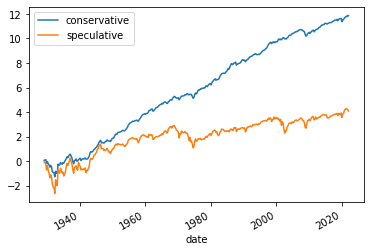

In [32]:
np.log((conservative_ret+1).cumprod()).plot()
np.log((speculative_ret+1).cumprod()).plot()
plt.legend(["conservative", "speculative"])

In [33]:
compare = pd.concat([speculative_ret, conservative_ret], axis=1)
compare = compare[compare.index <= "2016-12-31"]
compare.columns = ["speculative", "conservative"]
compare["decade"] = (compare.index.year) // 10 * 10
((compare+1).groupby("decade").prod() ** (0.1)) - 1

,speculative,conservative
decade,,
1921,-0.068573,-0.016575
1931,0.035615,0.036359
1941,0.136807,0.178885
1951,0.126121,0.225967
1961,0.036454,0.134633
1971,-0.022761,0.123363
1981,0.047004,0.217328
1991,0.085677,0.158156
2001,-0.019414,0.074063


In [34]:
#compare[compare.index <= "1939-12-31"]

## Market portfolio

In [35]:
vwp = pd.read_csv("../data/CRSP/VWP.csv", index_col=0)
vwp.index = pd.to_datetime(vwp.index.astype(str))
market_qret = (np.exp(np.log(vwp["vwretd"]+1).rolling(3).sum())-1).shift(-2)

In [36]:
market_ret = market_qret.loc[conservative_ret.index]

Text(0.5, 1.0, 'Value of $100 dollar invested in 1929')

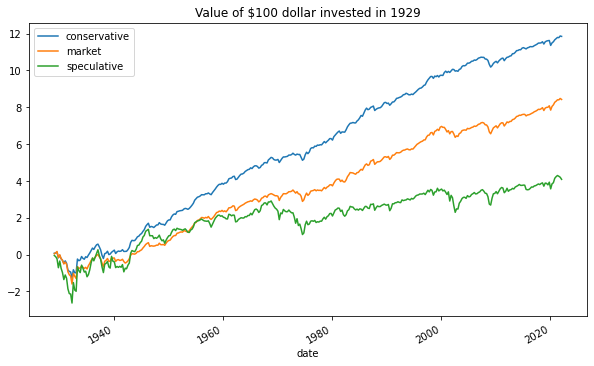

In [37]:
plt.figure(figsize=(10, 6))
np.log((conservative_ret+1).cumprod()).plot()
np.log((market_ret+1).cumprod()).plot()
np.log((speculative_ret+1).cumprod()).plot()
plt.legend(["conservative", "market", "speculative"])
plt.title("Value of $100 dollar invested in 1929")

In [38]:
compare_all = pd.concat([conservative_ret, market_ret, speculative_ret], axis=1)
compare_all = compare_all[compare_all.index <= "2016-12-31"]
compare_all.columns = ["conservative", "market", "speculative"]
compare_all["decade"] = (compare_all.index.year) // 10 * 10
compare_result = ((compare_all+1).groupby("decade").prod() ** (0.1)) - 1
compare_result.iloc[-1] = compare_result.iloc[-1] ** (10 / 7)
compare_result.index = (compare_result.index-1).astype(str)+'s'

Text(0.5, 1.0, 'Never a lost decade')

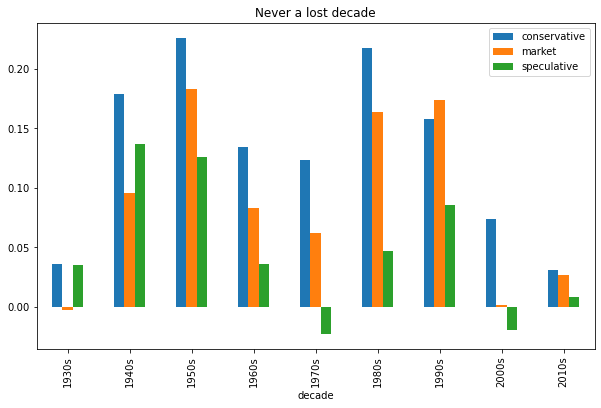

In [39]:
compare_result.iloc[1:].plot.bar(figsize=(10, 6))
plt.title("Never a lost decade")